<a href="https://colab.research.google.com/github/ydblank/ModelSelectionExercise/blob/main/Model_Selection_and_Hypertuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Selection and Hypertuning





## Load the necessary packages

In [36]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint #Continuous values for randomized
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV #Hypertuning
from sklearn.model_selection import cross_val_score #For cross-validation
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import ARDRegression
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.svm import NuSVR
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")

## Load the data

In [37]:
df = pd.read_csv('17-Advertising.csv')
df.head()


,ID,TV,Radio,Newspaper,Sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


## Remove unnecessary features

In [38]:
df = df.drop(["ID"],axis=1) #further simplification and highlight unique features

## Create training and test datasets

In [39]:
X = df.drop(['Sales'], axis=1)
y = df['Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) #data split 70:30, reproducability

## Scale the data

In [40]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) #sets mean to 0 and standard deviation to 1
X_test = scaler.transform(X_test) #to not apply to test

## Apply model selection

In [41]:
regressors = {
    "LinearSVR": LinearSVR(),
    "ElasticNet": ElasticNet(),
    "XGBRegressor": XGBRegressor(),
    "ARDRegression": ARDRegression(),
    "LinearRegression": LinearRegression(),
    "RandomForestRegressor": RandomForestRegressor(),
    "DecisionTreeRegressor": DecisionTreeRegressor(),
    "GaussianProcessRegressor": GaussianProcessRegressor(),
    "PassiveAggressiveRegressor": PassiveAggressiveRegressor(),
}

In [42]:
df_models = pd.DataFrame(columns=['model', 'run_time', 'rmse', 'rmse_cv']) #root mean squared error

for key in regressors: #dictionary of models

    print('*',key)

    start_time = time.time()

    regressor = regressors[key]
    model = regressor.fit(X_train, y_train) #training
    y_pred = model.predict(X_test) #testing

    scores = cross_val_score(model,
                             X_train,
                             y_train,
                             scoring="neg_mean_squared_error",
                             cv=10) #iterations of cross validation

    row = {'model': key,
           'run_time': format(round((time.time() - start_time)/60,2)),
           'rmse': round(np.sqrt(mean_squared_error(y_test, y_pred))),
           'rmse_cv': round(np.mean(np.sqrt(-scores)))
    }#metrics

    df_models.loc[len(df_models)] = row

* LinearSVR
* ElasticNet
* XGBRegressor


* ARDRegression
* LinearRegression
* RandomForestRegressor
* DecisionTreeRegressor
* GaussianProcessRegressor
* PassiveAggressiveRegressor


In [43]:
df_models.head(20).sort_values(by='run_time', ascending=True) #sort and show performance of each model

,model,run_time,rmse,rmse_cv
0,LinearSVR,0.0,1,2
1,ElasticNet,0.0,2,3
3,ARDRegression,0.0,1,2
4,LinearRegression,0.0,1,2
6,DecisionTreeRegressor,0.0,1,1
7,GaussianProcessRegressor,0.0,3,3
8,PassiveAggressiveRegressor,0.0,2,2
2,XGBRegressor,0.01,1,1
5,RandomForestRegressor,0.04,1,1


In [44]:
df_models.head(20).sort_values(by='rmse', ascending=True) #sort and show performance of each model

,model,run_time,rmse,rmse_cv
0,LinearSVR,0.0,1,2
2,XGBRegressor,0.01,1,1
3,ARDRegression,0.0,1,2
4,LinearRegression,0.0,1,2
5,RandomForestRegressor,0.04,1,1
6,DecisionTreeRegressor,0.0,1,1
1,ElasticNet,0.0,2,3
8,PassiveAggressiveRegressor,0.0,2,2
7,GaussianProcessRegressor,0.0,3,3


In [45]:
df_models.head(20).sort_values(by='rmse_cv', ascending=True) #sort and show performance of each model

,model,run_time,rmse,rmse_cv
2,XGBRegressor,0.01,1,1
5,RandomForestRegressor,0.04,1,1
6,DecisionTreeRegressor,0.0,1,1
0,LinearSVR,0.0,1,2
3,ARDRegression,0.0,1,2
4,LinearRegression,0.0,1,2
8,PassiveAggressiveRegressor,0.0,2,2
1,ElasticNet,0.0,2,3
7,GaussianProcessRegressor,0.0,3,3


## Assess the top performing model

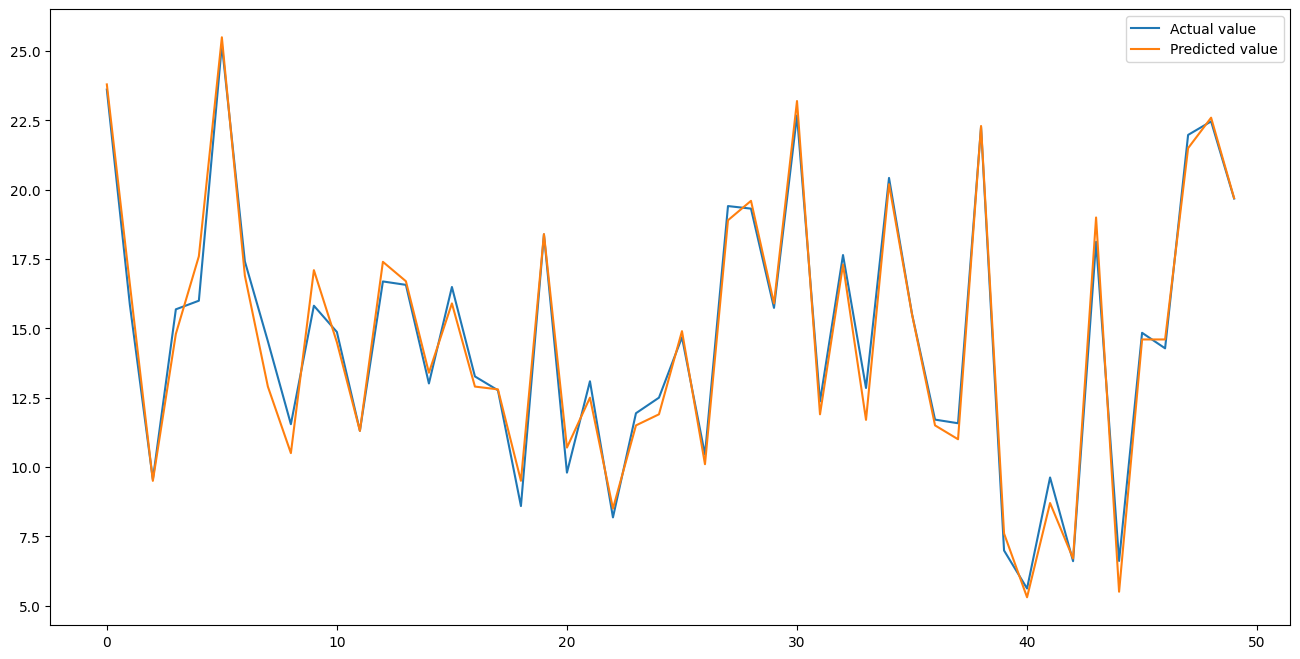

In [46]:
regressor = XGBRegressor()
model = regressor.fit(X_train, y_train) #training
y_pred = model.predict(X_test) #testing
test = pd.DataFrame({'Predicted value':y_pred, 'Actual value':y_test})
fig= plt.figure(figsize=(16,8)) #plotting
test = test.reset_index()
test = test.drop(['index'],axis=1)
plt.plot(test[:50])
plt.legend(['Actual value','Predicted value'])

## Tune the model’s hyperparameters

In [47]:
model.get_params()
{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': np.nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [48]:
param_grid = dict(  #grid-search parameters
    n_jobs=[16],
    learning_rate=[0.1, 0.5],
    objective=['reg:squarederror'],
    gamma=[0.05, 0.5],
    scale_pos_weight=[0, 1],
    reg_alpha=[0, 0.5],
    reg_lambda=[1, 0],
)

model = XGBRegressor(random_state=1, verbosity=1)

grid_search = GridSearchCV(estimator=model, #gridsearch func
                           param_grid=param_grid,
                           scoring='neg_root_mean_squared_error', #minimize RMSE
                           )

best_model = grid_search.fit(X_train, y_train) #store best parameters
print('Optimum parameters', best_model.best_params_)

Optimum parameters {'gamma': 0.05, 'learning_rate': 0.1, 'n_jobs': 16, 'objective': 'reg:squarederror', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 0}


## Fit the best model

In [49]:
regressor = XGBRegressor( #best parameters
    gamma=0.05,
    learning_rate=0.1,
    max_depth=5,
    n_estimators=1000,
    n_jobs=16,
    objective='reg:squarederror',
    subsample=0.8,
    scale_pos_weight=0,
    reg_alpha=0,
    reg_lambda=1
)
model = regressor.fit(X_train, y_train) #train
y_pred = model.predict(X_test) #test

np.sqrt(mean_squared_error(y_test, y_pred)) #show rmse

0.6379762800130676

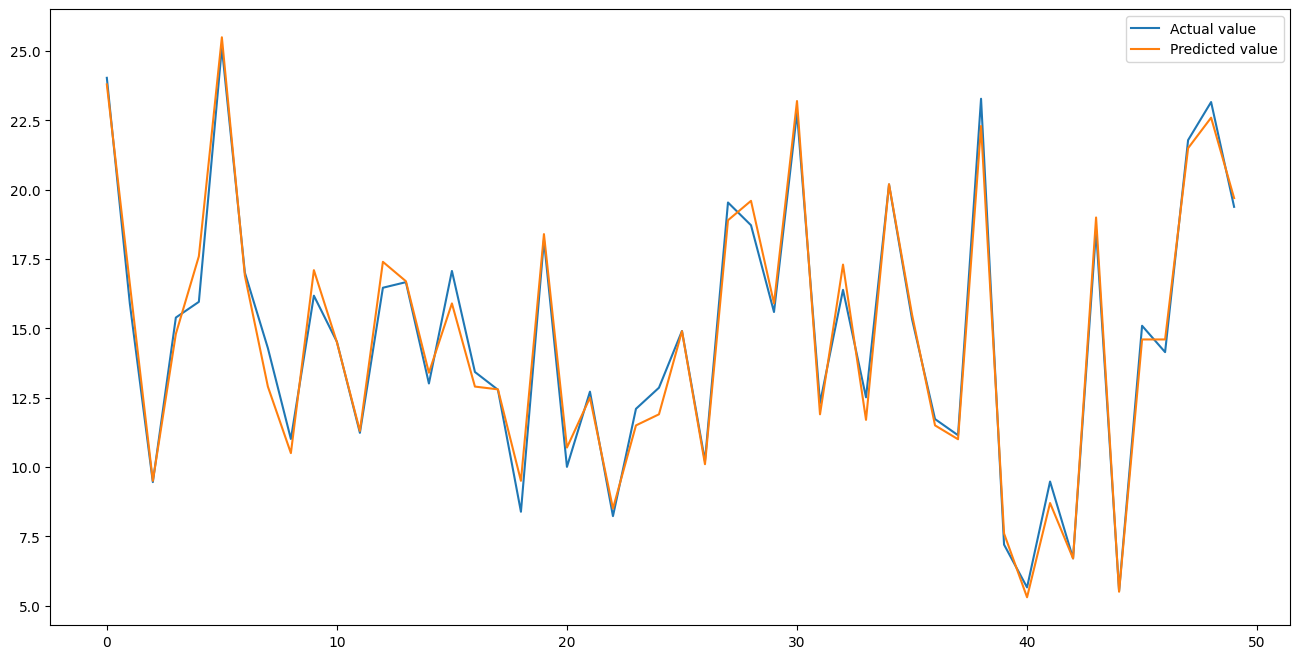

In [50]:
test = pd.DataFrame({'Predicted value':y_pred, 'Actual value':y_test})
fig= plt.figure(figsize=(16,8))
test = test.reset_index()
test = test.drop(['index'],axis=1)
plt.plot(test[:50])
plt.legend(['Actual value','Predicted value']) #plot

In [51]:
param_dist = {
    'n_jobs': [16],
    'learning_rate': [0.1, 0.5],
    'objective': ['reg:squarederror'],
    'gamma': uniform(0.05, 0.45),  # Random values between 0.05 and 0.5
    'scale_pos_weight': [0, 1],
    'reg_alpha': uniform(0, 0.5),  # Random values between 0 and 0.5
    'reg_lambda': [1, 0],
}
n_iter_search = 20 #iteration
model = XGBRegressor(random_state=1, verbosity=1)
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=n_iter_search,
    scoring='neg_root_mean_squared_error',
    n_jobs=1,  # Set to the desired number of parallel jobs
    random_state=42,
    cv=5  # cross-validation iteration
)
best_model = random_search.fit(X_train, y_train) #store best parameters
print('Optimum parameters:', best_model.best_params_)
final_model = best_model.best_estimator_.fit(X_train, y_train) #train
y_pred = final_model.predict(X_test) #test
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
print('Test RMSE:', rmse_test)

Optimum parameters: {'gamma': 0.18332307756683708, 'learning_rate': 0.1, 'n_jobs': 16, 'objective': 'reg:squarederror', 'reg_alpha': 0.03727532183988541, 'reg_lambda': 1, 'scale_pos_weight': 0}
Test RMSE: 0.6275560639383607


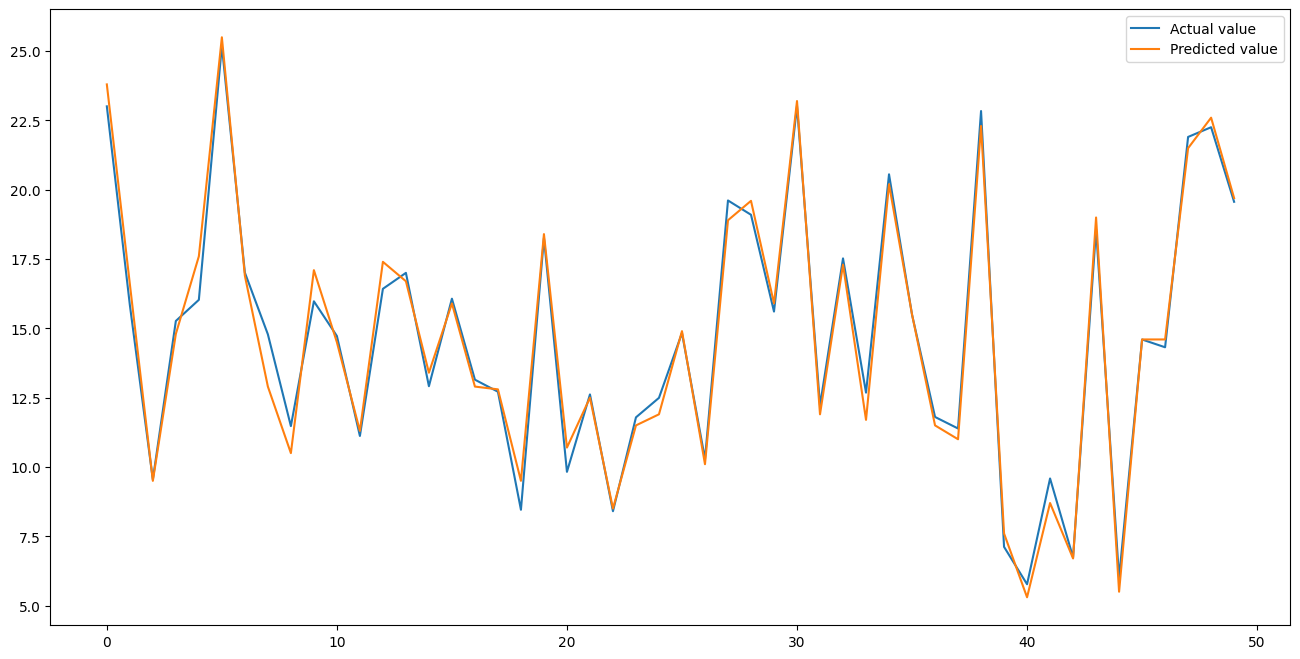

In [52]:
test = pd.DataFrame({'Predicted value': y_pred, 'Actual value': y_test})
fig = plt.figure(figsize=(16, 8))
test = test.reset_index()
test = test.drop(['index'], axis=1)
plt.plot(test[:50])
plt.legend(['Actual value', 'Predicted value'])
plt.show()